In [93]:
import numpy as np

In [94]:
def debug_initial_weights(fan_out, fan_in):
    w = np.zeros((fan_out, 1 + fan_in))
    w = np.sin(np.arange(w.size)).reshape(w.shape) / 10

    return w

In [95]:
def compute_numerial_gradient(cost_func, theta):
    numgrad = np.zeros(theta.size)
    perturb = np.zeros(theta.size)
    e = 1e-4
    for p in range(theta.size):
        # Set perturbation vector
        perturb[p] = e
        loss1, _ = cost_func(theta - perturb)
        loss2, _ = cost_func(theta + perturb)

        # Compute Numerical Gradient
        numgrad[p] = (loss2 - loss1) / (2 * e)
        perturb[p] = 0
    
    return numgrad

In [96]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [97]:
def nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmd):
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].reshape((hidden_layer_size, input_layer_size + 1))
    theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].reshape((num_labels, hidden_layer_size + 1))

    # Setup some useful variables
    m = y.size

    # You need to return the following variables correctly
    J = 0
    theta1_grad = np.zeros(theta1.shape)
    theta2_grad = np.zeros(theta2.shape)

    # ===================== Your Code Here =====================
    # Instructions : You should complete the code by working through the
    #                following parts
    #
    # Part 1 : Feedforward the neural network and return the cost in the
    #          variable cost. After implementing Part 1, you can verify that your
    #          cost function computation is correct by running ex4.py
    #
    # Part 2: Implement the backpropagation algorithm to compute the gradients
    #         theta1_grad and theta2_grad. You should return the partial derivatives of
    #         the cost function with respect to theta1 and theta2 in theta1_grad and
    #         theta2_grad, respectively. After implementing Part 2, you can check
    #         that your implementation is correct by running checkNNGradients
    #
    #         Note: The vector y passed into the function is a vector of labels
    #               containing values from 1..K. You need to map this vector into a 
    #               binary vector of 1's and 0's to be used with the neural network
    #               cost function.
    #
    #         Hint: We recommend implementing backpropagation using a for-loop
    #               over the training examples if you are implementing it for the 
    #               first time.
    #
    # Part 3: Implement regularization with the cost function and gradients.
    #
    #         Hint: You can implement this around the code for
    #               backpropagation. That is, you can compute the gradients for
    #               the regularization separately and then add them to theta1_grad
    #               and theta2_grad from Part 2.
    #

    label = np.zeros((m, num_labels))
    for i in range(m):
        label[i, y[i] - 1] = 1

    a1 = np.c_[np.ones(m), X]
    a2 = np.c_[np.ones(m), sigmoid(np.dot(a1, theta1.T))]
    hypothesis = sigmoid(np.dot(a2, theta2.T))

    reg_theta1 = theta1[:, 1:]
    reg_theta2 = theta2[:, 1:]

    J = np.sum(label * np.log(hypothesis) + (1 - label) * np.log(1 - hypothesis)) / (-m) \
    + (lmd / (2 * m)) * (np.sum(reg_theta1 * reg_theta1) + np.sum(reg_theta2 * reg_theta2))

    e3 = hypothesis - label
    e2 = np.dot(e3, theta2) * (a2 * (1 - a2))
    e2 = e2[:, 1:]

    delta1 = np.dot(e2.T, a1)
    delta2 = np.dot(e3.T, a2)

    theta1_grad = delta1 / m + (lmd / m) * np.c_[np.zeros(hidden_layer_size), reg_theta1]
    theta2_grad = delta2 / m + (lmd / m) * np.c_[np.zeros(num_labels), reg_theta2]
    # ====================================================================================

    # Unroll gradients
    grad = np.concatenate([theta1_grad.flatten(), theta2_grad.flatten()])
    
    return J, grad

In [98]:
def check_nn_gradients(lmd):
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5

    # We generatesome 'random' test data
    theta1 = debug_initial_weights(hidden_layer_size, input_layer_size)
    theta2 = debug_initial_weights(num_labels, hidden_layer_size)

    # Reusing debugInitializeWeights to generate X
    X = debug_initial_weights(m, input_layer_size - 1)
    y = 1 + np.mod(np.arange(1, m + 1), num_labels)

    # Unroll parameters
    nn_params = np.concatenate([theta1.flatten(), theta2.flatten()])

    # Short hand for cost function
    def cost_func(p):
        return nn_cost_function(p, input_layer_size, hidden_layer_size, num_labels, X, y, lmd)
    
    cost, grad = cost_func(nn_params)
    numgrad = compute_numerial_gradient(cost_func, nn_params)
    
    print(np.c_[grad, numgrad])

In [99]:
import matplotlib.pyplot as plt

In [100]:
def display_data(X):
    # Compute rows, cols
    m, n = X.shape
    example_width = np.round(np.sqrt(n)).astype(int)
    example_height = (n / example_width).astype(int)

    # Compute number of items to display
    display_rows = np.floor(np.sqrt(m)).astype(int)
    display_cols = np.ceil(m / display_rows).astype(int)

    # Between images padding
    pad = 1

    # Setup blank display
    display_array = - np.ones((pad + display_rows * (example_height + pad),
                              pad + display_cols * (example_width + pad)))
    # Copy each example into a patch on the display array
    curr_ex = 0
    for j in range(display_rows):
        for i in range(display_cols):
            if curr_ex >= m:
                break

            # Copy the patch
            # Get the max value of the patch
            max_val = np.max(np.abs(X[curr_ex]))
            display_array[pad + j * (example_height + pad) + np.arange(example_height),
                          pad + i * (example_width + pad) + np.arange(example_width)[:, np.newaxis]] = \
                          X[curr_ex].reshape((example_height, example_width)) / max_val
            curr_ex += 1
        if curr_ex >= m:
            break
    
    # Display Image
    plt.figure()
    plt.imshow(display_array, cmap='gray', extent=[-1, 1, -1, 1])
    plt.axis('off')

In [101]:
def predict(theta1, theta2, X):
    # Useful values
    m, _ = X.shape

    h1 = sigmoid(np.dot(np.c_[np.ones(m), X], theta1.T))
    h2 = sigmoid(np.dot(np.c_[np.ones(m), h1], theta2.T))

    return np.argmax(h2, axis=1) + 1

In [102]:
def rand_initialize_weights(l_in, l_out):
    # You need to return the following variable correctly
    w = np.zeros((l_out, 1 + l_in))

    # ===================== Your Code Here =====================
    # Instructions : Initialize w randomly so that we break the symmetry while
    #                training the neural network
    #
    # Note : The first column of w corresponds to the parameters for the bias unit
    #

    ep_init = 0.1
    w = np.random.rand(l_out, 1 + l_in) * (2 * ep_init) - ep_init

    # ===========================================================

    return w

In [103]:
def sigmoid_gradient(z):
    g = np.zeros(z.shape)

    # ===================== Your Code Here =====================
    # Instructions : Compute the gradient of the sigmoid function evaluated at
    #                each value of z (z can be a matrix, vector or scalar)
    #

    g = sigmoid(z) * (1 - sigmoid(z))

    # ===========================================================
    
    return g

In [104]:
# Setup the parameters you will use for this part of the exercise
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

## Part 1: Loading and Visualizing Data

In [105]:
import scipy.io as scio
import scipy.optimize as opt

In [106]:
data = scio.loadmat('/content/drive/MyDrive/Coursera_ML/Exer_4/ex4data1.mat')
X = data['X']
y = data['y']
m = y.size

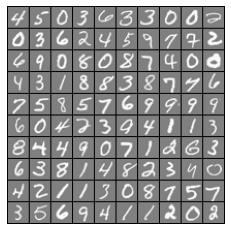

In [107]:
# Randomly select 100 data points to display
sel = np.random.permutation(range(m))
sel = sel[:100]
display_data(X[sel, :])

## Part 2: Loading Parameters

In [108]:
# Load the weights into variables Theta1 and Theta2
data = scio.loadmat('/content/drive/MyDrive/Coursera_ML/Exer_4/ex4weights.mat')
theta1 = data['Theta1']
theta2 = data['Theta2']

# Unroll parameters
nn_params = np.concatenate([theta1.flatten(), theta2.flatten()])

## Part 3: Compute Cost (Feedforward)

In [109]:
lmd = 0
J, grad = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmd)

In [110]:
print('Cost at parameters (loaded from ex4weights): {:0.6f}\n(This value should be about 0.287629)'.format(J))

Cost at parameters (loaded from ex4weights): 0.287629
(This value should be about 0.287629)


## Part 4: Implement Regularization

In [111]:
lmd = 1
J, grad = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmd)

In [112]:
print('Cost at parameters (loaded from ex4weights): {:0.6f}\n(This value should be about 0.383770)'.format(J))

Cost at parameters (loaded from ex4weights): 0.383770
(This value should be about 0.383770)


## Part 5: Sigmoid Gradient

In [113]:
g = sigmoid_gradient(np.array([-1, -0.5, 0, 0.5, 1]))

In [114]:
print('Sigmoid gradient evaluated at [-1  -0.5  0  0.5  1]:\n{}'.format(g))

Sigmoid gradient evaluated at [-1  -0.5  0  0.5  1]:
[0.19661193 0.23500371 0.25       0.23500371 0.19661193]


## Part 6: Initializing Parameters

In [115]:
initial_theta1 = rand_initialize_weights(input_layer_size, hidden_layer_size)
initial_theta2 = rand_initialize_weights(hidden_layer_size, num_labels)

In [116]:
# Unroll parameters
initial_nn_params = np.concatenate([initial_theta1.flatten(), initial_theta2.flatten()])

## Part 7: Implement Backpropagation

In [117]:
# Check gradients by running checkNNGradients
check_nn_gradients(lmd=0)

[[ 9.01303866e-03  9.01303866e-03]
 [-6.08047127e-05 -6.08047146e-05]
 [-6.96665817e-06 -6.96665836e-06]
 [ 5.32765097e-05  5.32765099e-05]
 [ 1.17193332e-02  1.17193332e-02]
 [-7.05495376e-05 -7.05495351e-05]
 [ 1.66652194e-04  1.66652196e-04]
 [ 2.50634667e-04  2.50634666e-04]
 [ 3.66087511e-03  3.66087511e-03]
 [-1.54510225e-05 -1.54510182e-05]
 [ 1.86817175e-04  1.86817173e-04]
 [ 2.17326523e-04  2.17326523e-04]
 [-7.76550109e-03 -7.76550108e-03]
 [ 5.38947948e-05  5.38947953e-05]
 [ 3.53029178e-05  3.53029161e-05]
 [-1.57462990e-05 -1.57462998e-05]
 [-1.20637760e-02 -1.20637760e-02]
 [ 7.36351996e-05  7.36352002e-05]
 [-1.48712777e-04 -1.48712773e-04]
 [-2.34334912e-04 -2.34334914e-04]
 [ 3.02286353e-01  3.02286353e-01]
 [ 1.51010770e-01  1.51010770e-01]
 [ 1.45233242e-01  1.45233242e-01]
 [ 1.58998192e-01  1.58998192e-01]
 [ 1.46779086e-01  1.46779086e-01]
 [ 1.48987769e-01  1.48987769e-01]
 [ 9.95931723e-02  9.95931723e-02]
 [ 4.96122519e-02  4.96122519e-02]
 [ 4.83540132e-02  4

## Part 8: Implement Regularization

In [118]:
# Check gradients by running checkNNGradients
lmd = 3
check_nn_gradients(lmd)

[[ 0.00901304  0.00901304]
 [ 0.05042745  0.05042745]
 [ 0.05455088  0.05455088]
 [ 0.00852048  0.00852048]
 [ 0.01171933  0.01171933]
 [-0.05760601 -0.05760601]
 [-0.01659828 -0.01659828]
 [ 0.03966983  0.03966983]
 [ 0.00366088  0.00366088]
 [ 0.02471166  0.02471166]
 [-0.03245445 -0.03245445]
 [-0.05978209 -0.05978209]
 [-0.0077655  -0.0077655 ]
 [ 0.02526392  0.02526392]
 [ 0.05947174  0.05947174]
 [ 0.03900152  0.03900152]
 [-0.01206378 -0.01206378]
 [-0.05761021 -0.05761021]
 [-0.04520795 -0.04520795]
 [ 0.0087583   0.0087583 ]
 [ 0.30228635  0.30228635]
 [ 0.20149903  0.20149903]
 [ 0.19979109  0.19979109]
 [ 0.16746539  0.16746539]
 [ 0.10137094  0.10137094]
 [ 0.09145231  0.09145231]
 [ 0.09959317  0.09959317]
 [ 0.08903145  0.08903145]
 [ 0.10771551  0.10771551]
 [ 0.07659312  0.07659312]
 [ 0.01589163  0.01589163]
 [-0.01062105 -0.01062105]
 [ 0.09693242  0.09693242]
 [ 0.07411068  0.07411068]
 [ 0.10599418  0.10599418]
 [ 0.089544    0.089544  ]
 [ 0.03040615  0.03040615]
 

In [119]:
# Also output the cost_function debugging values
debug_J, _ = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmd)

In [120]:
print('Cost at (fixed) debugging parameters (w/ lambda = {}): {:0.6f}\n(for lambda = 3, this value should be about 0.576051)'.format(lmd, debug_J))

Cost at (fixed) debugging parameters (w/ lambda = 3): 0.576051
(for lambda = 3, this value should be about 0.576051)


## Part 9: Training NN

In [121]:
lmd = 1

In [122]:
def cost_func(p):
    return nn_cost_function(p, input_layer_size, hidden_layer_size, num_labels, X, y, lmd)[0]

def grad_func(p):
    return nn_cost_function(p, input_layer_size, hidden_layer_size, num_labels, X, y, lmd)[1]

In [123]:
nn_params, *unused = opt.fmin_cg(cost_func, fprime=grad_func, x0=nn_params, maxiter=400, disp=True, full_output=True)

         Current function value: 0.308290
         Iterations: 400
         Function evaluations: 952
         Gradient evaluations: 952


In [124]:
# Obtain theta1 and theta2 back from nn_params
theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].reshape(hidden_layer_size, input_layer_size + 1)
theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].reshape(num_labels, hidden_layer_size + 1)

## Part 10: Visualize Weights

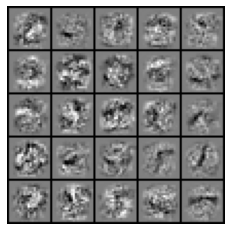

In [125]:
display_data(theta1[:, 1:])

## Part 11: Implement Predict

In [126]:
pred = predict(theta1, theta2, X)

In [127]:
print('Training set accuracy: {}'.format(np.mean(pred == y)*100))

Training set accuracy: 10.0
